In [1]:
from datascience import *
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.simplefilter(action='ignore')
%matplotlib inline

In [2]:
def standard_units(x):
    return (x - np.mean(x))/np.std(x)

In [36]:
def distance(point1, point2):
    """The distance between two arrays of numbers."""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, point):
    """The distance between p (an array of numbers) and the numbers in row i of attribute_table."""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance(point, np.array(row))
    return attributes.apply(distance_from_point)

def table_with_distances(training, point):
    """A copy of the training table with the distance from each row to array p."""
    return training.with_column('Distance', all_distances(training, point))

def closest(training, point, k):
    """A table containing the k closest rows in the training table to array p."""
    with_dists = table_with_distances(training, point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

def majority(topkclasses):
    """1 if the majority of the "Class" column is 1s, and 0 otherwise."""
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, p, k):
    """Classify an example with attributes p using k-nearest neighbor classification with the given training table."""
    closestk = closest(training, p, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

def show_closest(point):
    """point = array([x,y]) 
    gives the coordinates of a new point
    shown in red"""
    
    HemoGl = ckd.drop('White Blood Cell Count', 'Color')
    t = closest(HemoGl, point, 1)
    x_closest = t.row(0).item(1)
    y_closest = t.row(0).item(2)
    ckd.scatter('Hemoglobin', 'Glucose', group='Color')
    plt.scatter(point.item(0), point.item(1), color='red', s=30)
    plt.plot(make_array(point.item(0), x_closest), make_array(point.item(1), y_closest), color='k', lw=2);

In [4]:
def plot_all_points(test_grid):
    test_grid.scatter('Hemoglobin', 'Glucose', color='red', alpha=0.4, s=30)

    plt.scatter(ckd.column('Hemoglobin'), ckd.column('Glucose'), c=ckd.column('Color'), edgecolor='k')

    plt.xlim(-2, 2)
    plt.ylim(-2, 2);
    
def classify_grid(training, test, k):
    c = make_array()
    for i in range(test.num_rows):
        # Run the classifier on the ith patient in the test set
        c = np.append(c, classify(training, make_array(test.row(i)), k))   
    return c

def plot_all_points_classified(test_grid):
    c = classify_grid(ckd.drop('White Blood Cell Count', 'Color'), test_grid, 1)
    test_grid = test_grid.with_column('Class', c).join('Class', color_table)
    test_grid.scatter('Hemoglobin', 'Glucose', group='Color', alpha=0.4, s=30)

    plt.scatter(ckd.column('Hemoglobin'), ckd.column('Glucose'), c=ckd.column('Color'), edgecolor='k')

    plt.xlim(-2, 2)
    plt.ylim(-2, 2);

# Lecture 16
## Classification Examples
### Classifying Patients

In [5]:
ckd = Table.read_table('data/ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd.show(3)

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,1
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,1
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,1


In [6]:
ckd.group('Class')
# class 0 - False - No Chronic Kidney disease
# class 1 - True - Chronic Kidney disease

Class,count
0,115
1,43


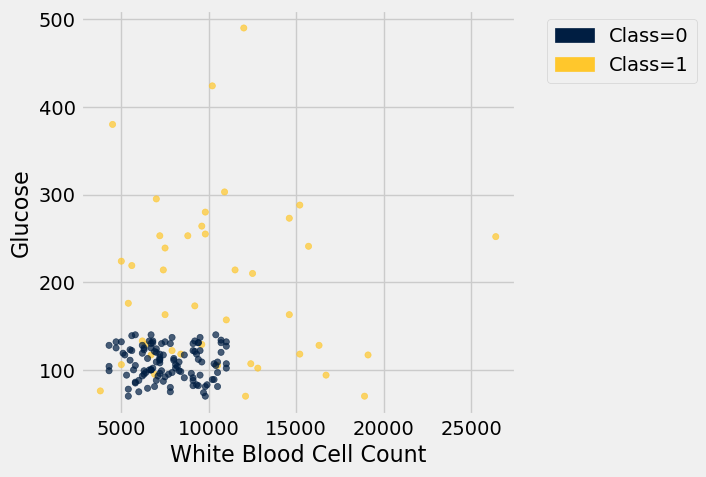

In [7]:
ckd.scatter('White Blood Cell Count', 'Glucose', group='Class')

# What values of White Blood Cell count and Glucose levels do we see that our patients have chronic kidney disease?

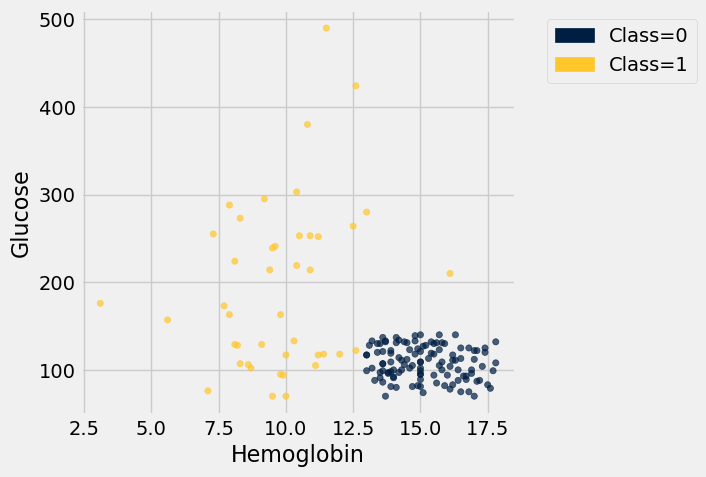

In [8]:
ckd.scatter('Hemoglobin', 'Glucose', group='Class')

# is there a clear threshold? for those who do not have chronic kidney disease, and those who do?
###
# the threshold is defined by our x- and y-axis, hemoglobin and glucose levels

In [9]:
# we want to be able to way to predict the class of someone
# without having to plot & eye ball this graph every time.
#
# one way to do this is to put some thresholds into code
max_glucose_for_0 = ckd.where('Class', are.equal_to(0)).column('Glucose').max()
# finding all our existing patient data, finding the patients without the disease
# finding the max glucose levels from those patients

min_hemoglobin_for_0 = ckd.where('Class', are.equal_to(0)).column('Hemoglobin').min()
max_glucose_for_0, min_hemoglobin_for_0


(140, 13.0)

In [12]:
def classify_manually(hemoglobin, glucose):
    if hemoglobin < min_hemoglobin_for_0 or glucose > max_glucose_for_0:
       return 1 # chronic kidney disease
    else:
        return 0 # no disease

In [13]:
# Let's try our classifier!
classify_manually(15, 100)

0

In [14]:
classify_manually(10, 300)

1

In [18]:
classify_manually_array = ckd.apply(classify_manually, 'Hemoglobin', 'Glucose')
ckd.with_column('Predictions', classify_manually_array).show()

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class,Predictions
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,1,1
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,1,1
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,1,1
68,80,1.01,3,2,normal,abnormal,present,present,157,90,4.1,130,6.4,5.6,16,11000,2.6,yes,yes,yes,poor,yes,no,1,1
61,80,1.015,2,0,abnormal,abnormal,notpresent,notpresent,173,148,3.9,135,5.2,7.7,24,9200,3.2,yes,yes,yes,poor,yes,yes,1,1
48,80,1.025,4,0,normal,abnormal,notpresent,notpresent,95,163,7.7,136,3.8,9.8,32,6900,3.4,yes,no,no,good,no,yes,1,1
69,70,1.01,3,4,normal,abnormal,notpresent,notpresent,264,87,2.7,130,4,12.5,37,9600,4.1,yes,yes,yes,good,yes,no,1,1
73,70,1.005,0,0,normal,normal,notpresent,notpresent,70,32,0.9,125,4,10,29,18900,3.5,yes,yes,no,good,yes,no,1,1
73,80,1.02,2,0,abnormal,abnormal,notpresent,notpresent,253,142,4.6,138,5.8,10.5,33,7200,4.3,yes,yes,yes,good,no,no,1,1
46,60,1.01,1,0,normal,normal,notpresent,notpresent,163,92,3.3,141,4,9.8,28,14600,3.2,yes,yes,no,good,no,no,1,1


## Classifying Banknotes 

In [19]:
banknotes = Table.read_table('data/banknote.csv')
banknotes

WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class
3.6216,8.6661,-2.8073,-0.44699,0
4.5459,8.1674,-2.4586,-1.4621,0
3.866,-2.6383,1.9242,0.10645,0
3.4566,9.5228,-4.0112,-3.5944,0
0.32924,-4.4552,4.5718,-0.9888,0
4.3684,9.6718,-3.9606,-3.1625,0
3.5912,3.0129,0.72888,0.56421,0
2.0922,-6.81,8.4636,-0.60216,0
3.2032,5.7588,-0.75345,-0.61251,0
1.5356,9.1772,-2.2718,-0.73535,0


In [20]:
banknotes.group('Class')
# Class 0 = Real banknote
# Class 1 = counterfeit banknote

Class,count
0,762
1,610


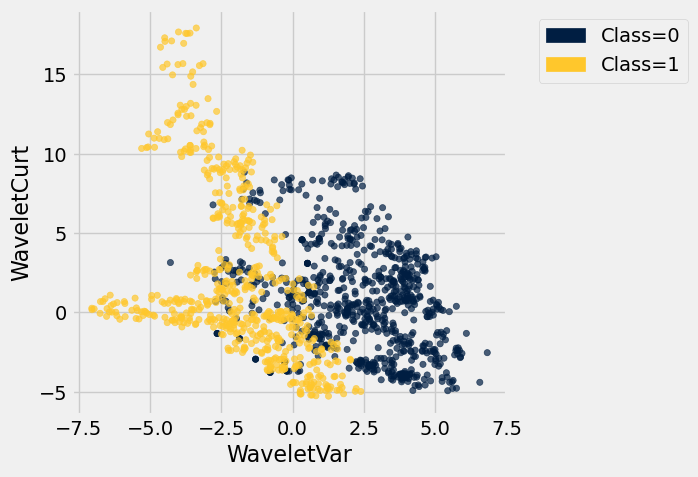

In [21]:
banknotes.scatter('WaveletVar', 'WaveletCurt', group = 'Class')
#what do you see?


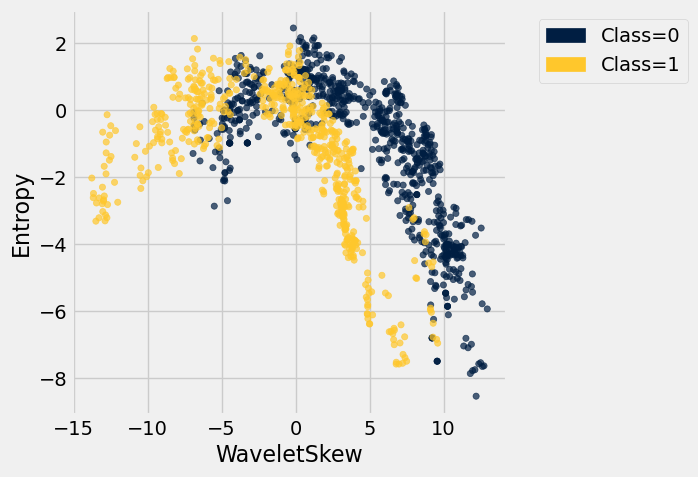

In [22]:
banknotes.scatter('WaveletSkew', 'Entropy', group = 'Class')

# what do you see here?
# what thresholds do you see, where the categorization/classification of class is clear?

# are these two attributes good ones to make some prediction on classification?

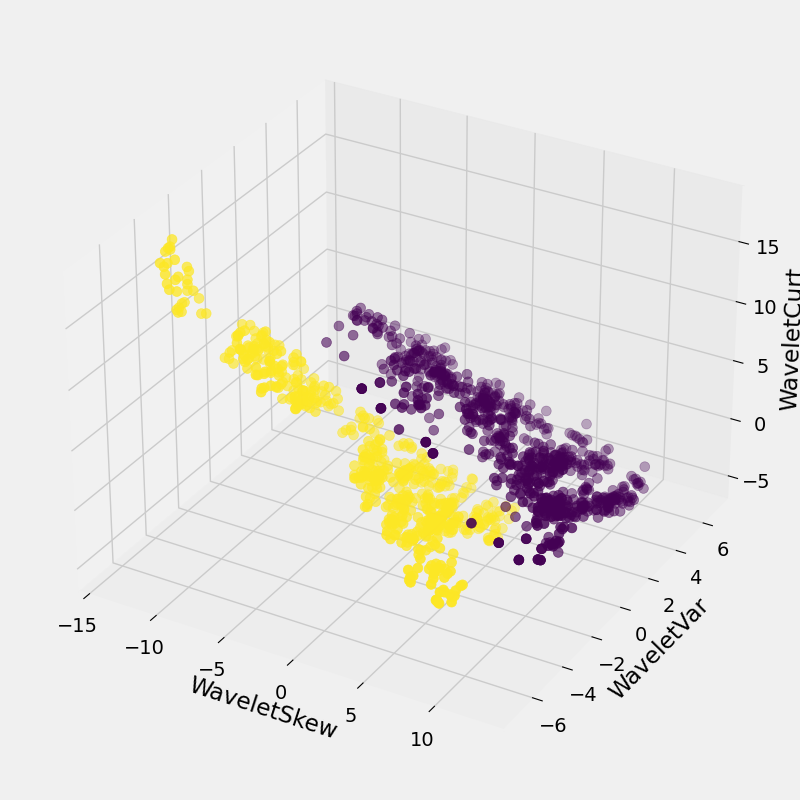

In [23]:
%matplotlib widget
fig = plt.figure(figsize=(8, 8)) 
ax = fig.add_subplot(projection='3d')
ax.scatter(banknotes.column('WaveletSkew'), 
           banknotes.column('WaveletVar'), 
           banknotes.column('WaveletCurt'), 
           c=banknotes.column('Class'),           
           cmap='viridis',           
           s=50)

ax.set_xlabel('WaveletSkew')
ax.set_ylabel('WaveletVar')
ax.set_zlabel('WaveletCurt')

fig.tight_layout()

---
back to slides

---
## Nearest Neighbor Classifer

In [24]:
%matplotlib inline

In [26]:
# convert features into standard units
ckd = Table().with_columns(
    'Hemoglobin', standard_units(ckd.column('Hemoglobin')),
    'Glucose', standard_units(ckd.column('Glucose')),
    'White Blood Cell Count', standard_units(ckd.column('White Blood Cell Count')),
    'Class', ckd.column('Class')
)
ckd

Hemoglobin,Glucose,White Blood Cell Count,Class
-0.865744,-0.221549,-0.569768,1
-1.45745,-0.947597,1.16268,1
-1.00497,3.84123,-1.27558,1
-2.81488,0.396364,0.809777,1
-2.08395,0.643529,0.232293,1
-1.35303,-0.561402,-0.505603,1
-0.413266,2.04928,0.360623,1
-1.28342,-0.947597,3.34429,1
-1.10939,1.87936,-0.409356,1
-1.35303,0.489051,1.96475,1


In [28]:
color_table = Table().with_columns(
    'Class', make_array(1,0),
    'Color', make_array('darkblue', 'gold')
)
ckd = ckd.join('Class', color_table)

Class,Hemoglobin,Glucose,White Blood Cell Count,Color,Color_2
0,0.456884,0.133751,0.617283,gold,gold
0,1.153,-0.947597,0.424788,gold,gold
0,0.770138,-0.762223,0.200211,gold,gold
0,0.596108,-0.190654,-0.73018,gold,gold
0,-0.239236,-0.49961,-0.0564489,gold,gold
0,-0.0304002,-0.159758,0.232293,gold,gold
0,0.282854,-0.00527964,0.71353,gold,gold
0,0.108824,-0.623193,0.200211,gold,gold
0,0.0740178,-0.515058,-0.0243664,gold,gold
0,0.83975,-0.422371,-1.33975,gold,gold


In [31]:
ckd = ckd.drop('Color_2')
ckd

Class,Hemoglobin,Glucose,White Blood Cell Count,Color
0,0.456884,0.133751,0.617283,gold
0,1.153,-0.947597,0.424788,gold
0,0.770138,-0.762223,0.200211,gold
0,0.596108,-0.190654,-0.73018,gold
0,-0.239236,-0.49961,-0.0564489,gold
0,-0.0304002,-0.159758,0.232293,gold
0,0.282854,-0.00527964,0.71353,gold
0,0.108824,-0.623193,0.200211,gold
0,0.0740178,-0.515058,-0.0243664,gold
0,0.83975,-0.422371,-1.33975,gold


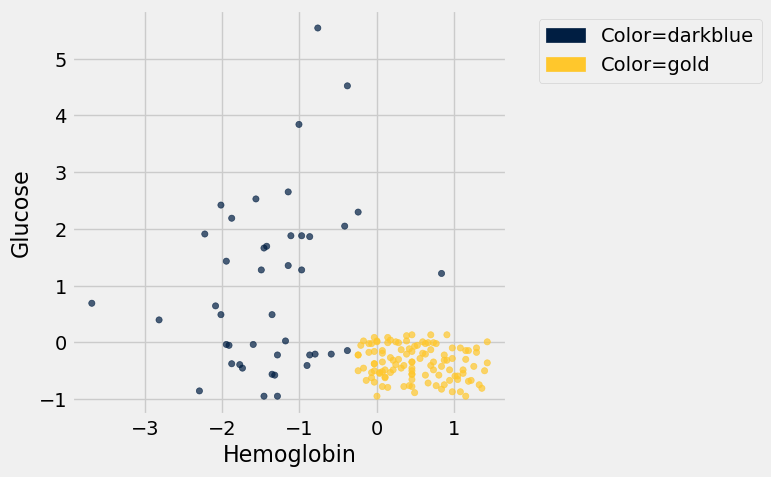

In [33]:
ckd.scatter('Hemoglobin', 'Glucose', group='Color')

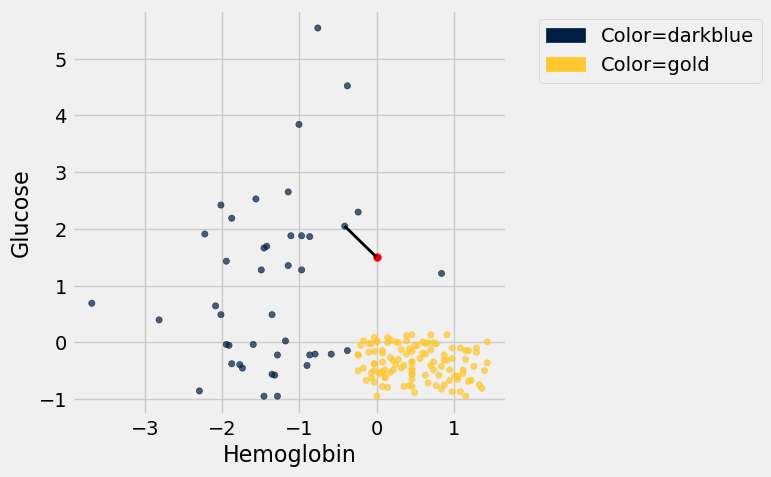

In [37]:
# In this example, Alice's Hemoglobin is 0 and her Glucose is 1.5.
alice = make_array(0, 1.5)
show_closest(alice)

## Decision Boundary

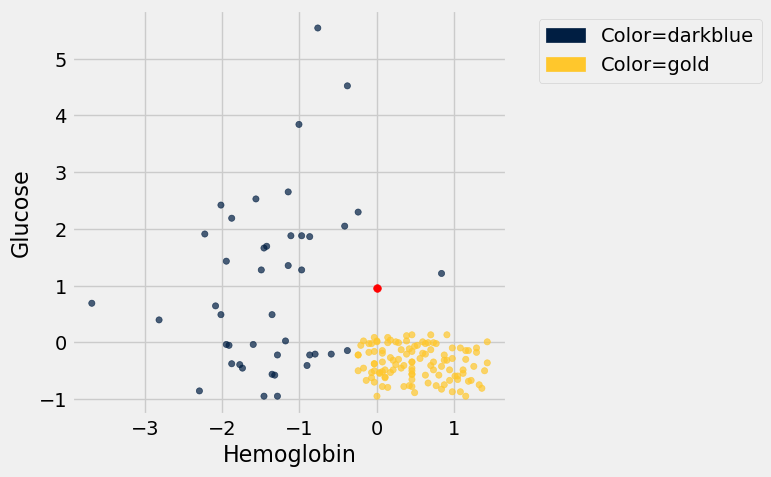

In [35]:
alice = make_array(0, 0.95)
show_closest(alice)

In [38]:
# Create a grid of all points
x_array = make_array()
y_array = make_array()
for x in np.arange(-2, 2.1, 0.1):
    for y in np.arange(-2, 2.1, 0.1):
        x_array = np.append(x_array, x)
        y_array = np.append(y_array, y)

test_grid = Table().with_columns(
    'Hemoglobin', x_array,
    'Glucose', y_array
)

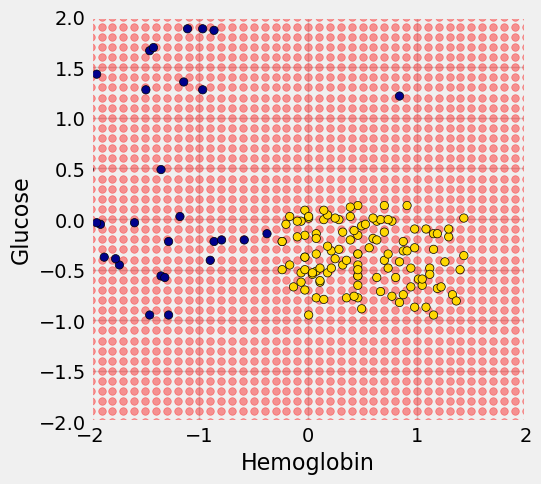

In [39]:
plot_all_points(test_grid)

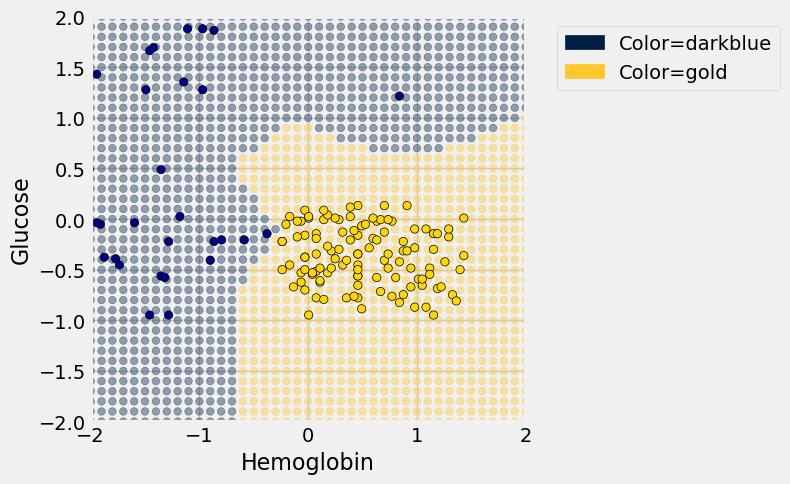

In [40]:
plot_all_points_classified(test_grid)